In [ ]:
!nvidia-smi

This notebook make take quite a bit longer than the quickstart notebook. We set $n_{max}=8$ for the shapelets because this is the minimal number needed to capture the spiral arms features on the source galaxy, resulting in slower modeling. This is in part due to the higher memory pressure associated with a large number of shapelets components.

In [ ]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic, shapelets
from gigalens.tf.profiles.mass import epl, shear, sis
import gigalens
sns.set_style("whitegrid")
tfd = tfp.distributions

In [ ]:
import gigalens
root = gigalens.__path__[0]
img = plt.imread(f'{root}/assets/spiral.jpeg')
img = img[:,131:-131]
img = np.sqrt(img[...,1].astype(np.float32))
img -= np.median(img[:20,:20])
img *= 100
from skimage.transform import downscale_local_mean
img = downscale_local_mean(img, (5,5))
img = np.pad(img, [(100, 100), (100, 100)], mode='constant')
grid = np.linspace(-1,1,len(img)).astype(np.float32)
xx,yy = np.meshgrid(grid,grid)
xx, yy = xx[np.newaxis,...,np.newaxis], yy[np.newaxis,...,np.newaxis]
n_max = 8
shp = shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=True)
components = np.squeeze(shp.light(xx, yy, beta=0.13, center_x=0, center_y=0))
X = components.reshape((shp.depth, -1))
Y = img.flatten()
sol, resid, _, _ = np.linalg.lstsq(X.T, Y)
plt.imshow((sol@X).reshape(img.shape))
plt.colorbar()

In [ ]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(tf.math.log(1.0), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.025),
                center_y=tfd.Normal(0, 0.025),
            )
        ),
    ]
)

amp_prior = {key: tfd.Normal(0,500/float(np.sqrt(i+1))) for i, key in enumerate(shapelets.Shapelets(n_max)._amp_names)}
source_light_params = dict(
    beta=tfd.LogNormal(tf.math.log(0.1), 0.15),
    center_x=tfd.Normal(0, 0.01),
    center_y=tfd.Normal(0, 0.01)
)

source_light_prior = tfd.JointDistributionSequential([tfd.JointDistributionNamed(source_light_params)])

prior = tfd.JointDistributionSequential(
    [lens_prior, source_light_prior]
)

Load the data. The ground truth parameters are in `truth`. Various hyperparameters, including the noise scale and exposure time are fixed.

The PSF is generated from `TinyTim` for HST F140W band, and has been supersampled to the pixel scale of 0.065.

In [ ]:
tf.random.set_seed(121)
truth = prior.sample(1)
truth[1][0] = {**truth[1][0], 
               **{f'amp{str(i).zfill(3)}': tf.convert_to_tensor([sol[i]]) for i in range(shp.depth)}, 
               'beta': tf.convert_to_tensor([0.08], dtype=tf.float32),
              }

In [ ]:
import gigalens
root = gigalens.__path__[0] + '/assets'
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=1)
phys_model = PhysicalModel([epl.EPL(), shear.Shear()], [], [shapelets.Shapelets(n_max=n_max, use_lstsq=False, interpolate=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = lens_sim.simulate(truth)
err_map = np.sqrt(0.1**2 + np.clip(observed_img, 0, np.inf)/200)
np.random.seed(1)
observed_img += np.random.normal(scale=err_map)

phys_model = PhysicalModel([epl.EPL(), shear.Shear()], [], [shapelets.Shapelets(n_max=n_max, use_lstsq=True, interpolate=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
prob_model = BackwardProbModel(prior, observed_img, background_rms=0.1, exp_time=200)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(observed_img)
plt.title('Observed image')
plt.colorbar() 
plt.xticks([])
plt.yticks([])
plt.subplot(122)
shp = shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=False)
grid = np.linspace(-1,1,1000).astype(np.float32)
a, b = np.meshgrid(grid,grid)
ret = shp.light(a[np.newaxis,...,np.newaxis], b[np.newaxis,...,np.newaxis], **truth[1][0])
plt.imshow(np.squeeze(ret))
plt.title('Source plane')
plt.grid(False)
plt.colorbar()

Begin fitting.

In [ ]:
fitter = ModellingSequence(phys_model, prob_model, sim_config)

See $\S2.3$: Maximum a Posteriori Estimate

In [ ]:
n_map = 100
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, n_map, 1e-2/10)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=n_map, num_steps=150, seed=0)

In [ ]:
# Simulator to evaluate the log likelihood of 100 candidate solutions
lens_sim_100 = LensSimulator(phys_model, sim_config, bs=n_map)
lps = prob_model.log_prob(lens_sim_100, MAP)[0]
best = MAP[tf.argmax(lps).numpy()]

See $\S2.4$: Variational Inference

In [ ]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 100, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=500, num_steps=350)

In [ ]:
plt.plot(losses)

See $\S2.5$: Hamiltonian Monte Carlo

In [ ]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

In [ ]:
Rhat = tf.nest.map_structure(tfp.mcmc.potential_scale_reduction, prob_model.bij.forward(samples))
ESS = tf.nest.map_structure(lambda x: tfp.mcmc.effective_sample_size(x,cross_chain_dims=1), prob_model.bij.forward(samples))
print('Rhat', Rhat)
print('ESS', ESS)

In [ ]:
get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['theta_E'],
    x[0][0]['gamma'],
    x[0][0]['e1'],
    x[0][0]['e2'],
    x[0][0]['center_x'],
    x[0][0]['center_y'],
    x[1][0]['beta'],
    x[1][0]['center_x'],
    x[1][0]['center_y'],
])
physical_samples = get_samples(prob_model.bij.forward(samples)).numpy()
markers = get_samples(truth).numpy().flatten()
labels=[r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x_{epl}$', r'$y_{epl}$', r'$\beta$', r'$x_s$', r'$y_s$']
corner(physical_samples.reshape((len(labels),-1)).T, truths=markers, 
       show_titles=True, title_fmt='.4f',
       labels=labels);

In [ ]:
mean_estimate = tf.nest.map_structure(lambda x: tf.reduce_mean(x, axis=(0,1),keepdims=True)[0], prob_model.bij.forward(samples))
plt.figure(figsize=(13,3))
plt.subplot(141)
plt.title('Recovered')
plt.imshow(lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map))
plt.xticks([])
plt.yticks([])
plt.subplot(142)
plt.title('Residual')
residual = (observed_img-lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map))/err_map
plt.imshow(residual, cmap='bwr', interpolation='none')
plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.subplot(143)
plt.title('Residual histogram')
plt.hist(residual.numpy().flatten(), range=(-4,4), density=True, bins=30)
plt.xlabel('Normalized Residual')

coeffs = np.squeeze(lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map, return_coeffs=True))
shp = shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=False)
grid = np.linspace(-1,1,1000).astype(np.float32)
a, b = np.meshgrid(grid,grid)
ret = shp.light(a[np.newaxis,...,np.newaxis], b[np.newaxis,...,np.newaxis], **mean_estimate[1][0], 
                **{shp._amp_names[i]: tf.convert_to_tensor([coeffs[i]]) for i in range(shp.depth)})
plt.subplot(144)
plt.title('Recovered source')
plt.imshow(np.squeeze(ret))
plt.xticks([])
plt.yticks([])
plt.tight_layout()

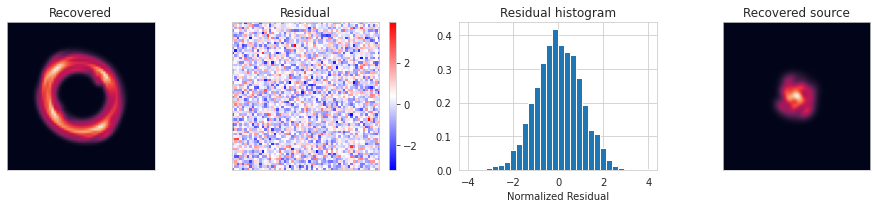

In [29]:
mean_estimate = tf.nest.map_structure(lambda x: tf.reduce_mean(x, axis=(0,1),keepdims=True)[0], prob_model.bij.forward(samples))
plt.figure(figsize=(13,3))
plt.subplot(141)
plt.title('Recovered')
plt.imshow(lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map))
plt.xticks([])
plt.yticks([])
plt.subplot(142)
plt.title('Residual')
residual = (observed_img-lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map))/err_map
plt.imshow(residual, cmap='bwr', interpolation='none')
plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.subplot(143)
plt.title('Residual histogram')
plt.hist(residual.numpy().flatten(), range=(-4,4), density=True, bins=30)
plt.xlabel('Normalized Residual')

coeffs = np.squeeze(lens_sim.lstsq_simulate(mean_estimate, observed_img, err_map, return_coeffs=True))
shp = shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=False)
grid = np.linspace(-1,1,1000).astype(np.float32)
a, b = np.meshgrid(grid,grid)
ret = shp.light(a[np.newaxis,...,np.newaxis], b[np.newaxis,...,np.newaxis], **mean_estimate[1][0], 
                **{shp._amp_names[i]: tf.convert_to_tensor([coeffs[i]]) for i in range(shp.depth)})
plt.subplot(144)
plt.title('Recovered source')
plt.imshow(np.squeeze(ret))
plt.xticks([])
plt.yticks([])
plt.tight_layout()